# Transfer Learning for VGG16 Model with RGB

This notebook includes code for finetunning a VGG16 model for classification with Keras on the RGB version of the eurosat dataset.

In [4]:
# Uncomment if running on mac GPU
#!pip install tensorflow-macos tensorflow-metal

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Preprocess images 
Download the RGB version of the eurosat database from tensorflow.datasets. Dataset includes 27,000 examples. 

In [5]:
ds_all, ds_info = tfds.load(
    "eurosat/rgb",
    split="train",
    with_info=True,
    as_supervised=True,
)
train_ds = ds_all.take(20000)
val_ds   = ds_all.skip(20000).take(5000)
test_ds  = ds_all.skip(25000).take(100)


Visualize an image from the training set

2025-05-03 13:55:49.599981: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


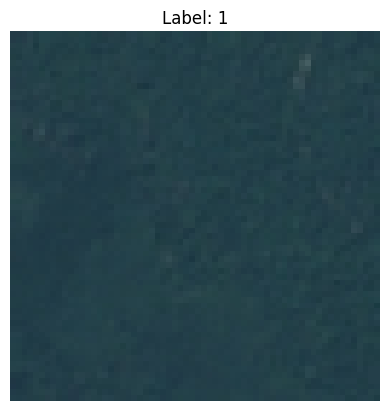

2025-05-03 13:55:49.649854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
for image, label in train_ds.take(1):
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"Label: {label.numpy()}")
    plt.axis("off")
    plt.show()

Preprocess the datasets to match the image size expected from VGG16.

1. Resizes the image to (224, 224) pixels, which is the input size expected by VGG16.

2. Applies preprocess_input from tensorflow.keras.applications.vgg16, which: 
    - converts the image to float32
    - Changes the color channel order from RGB to BGR
    - Subtracts the mean pixel values (specific to ImageNet: [103.939, 116.779, 123.68] for B, G, R channels).
3. Applies prefetch autotune, which allows tensorflow to prepare the next batch as the current one is loading for max efficiency. 

In [7]:
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # match VGG16 input size
    image = preprocess_input(tf.cast(image, tf.float32))
    return image, label

train_ds = train_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


## Transfer learning model 

Load the model (in this case VGG16 trained on imagenet) and extract it's convolutional base. These are the layers that extract the features from the images. 

We then freeze these layers from training and plug in a new classifier layer at the end with a custom number of classes. 

In [8]:
# Get the convolutional layers from the VGG16 model and configure to needs. 
conv_base = tf.keras.applications.VGG16(weights='imagenet', 
                                        include_top=False, 
                                        input_shape=(224, 224, 3))

The preprocess_input function ensures satellite images are formatted correctly so the model can extract meaningful features. It iterates over all the batches and returns two numpy arrays:   

1) The features, whose shape depends on the output of your conv_base (Samples, Height, Width, Channels).

2) The labels, which are stored in a one-dimensional array or two-dimensional (if one‐hot encoded).

In [9]:
def get_features_and_labels(dataset, conv_base):
    conv_base.trainable = False
    processed_images = preprocess_input(dataset)
    return processed_images

Now build the classifier layers that go ontop of the frozen convolutional base. 

In [10]:
# 1) grab the shape from your preprocessed ds
image_spec, _ = train_ds.element_spec
input_shape = image_spec.shape[1:]   # e.g. (224, 224, 3)

def build_model(input_shape=input_shape):
    conv_base.trainable = False  # freeze VGG16 layers
    inputs = tf.keras.Input(shape=input_shape)
    x = conv_base(inputs, training=False)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

Run the model and visualize the loss and accuracy throughout the training loop.

Epoch 1/5


2025-05-03 13:56:06.605391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7393 - loss: 13.3284

2025-05-03 13:57:38.372454: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7396 - loss: 13.3194

2025-05-03 13:58:02.750325: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 186ms/step - accuracy: 0.7397 - loss: 13.3149 - val_accuracy: 0.9232 - val_loss: 4.1674
Epoch 2/5
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9081 - loss: 5.3697

2025-05-03 13:59:40.856768: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9081 - loss: 5.3693

2025-05-03 14:00:04.943639: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


625/625 ━━━━━━━━━━━━━━━━━━━━ 122s 196ms/step - accuracy: 0.9081 - loss: 5.3691 - val_accuracy: 0.9314 - val_loss: 4.1343
Epoch 3/5
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9290 - loss: 3.8141

2025-05-03 14:01:43.583695: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9290 - loss: 3.8143

2025-05-03 14:02:08.235947: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


625/625 ━━━━━━━━━━━━━━━━━━━━ 123s 198ms/step - accuracy: 0.9290 - loss: 3.8144 - val_accuracy: 0.9408 - val_loss: 3.8961
Epoch 4/5
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9444 - loss: 3.2530

2025-05-03 14:04:06.588413: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9444 - loss: 3.2534

2025-05-03 14:04:34.031196: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 233ms/step - accuracy: 0.9444 - loss: 3.2535 - val_accuracy: 0.9326 - val_loss: 4.9972
Epoch 5/5
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9501 - loss: 2.9514

2025-05-03 14:06:30.539215: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9501 - loss: 2.9506

2025-05-03 14:06:55.899797: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.9502 - loss: 2.9502 - val_accuracy: 0.9340 - val_loss: 5.1353


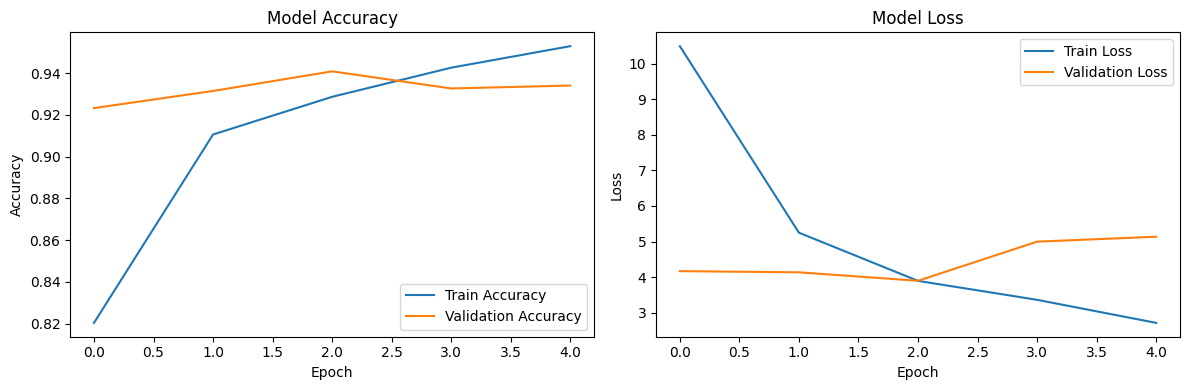

In [11]:
dense_model = build_model(input_shape)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = dense_model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=callbacks)

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Test model 
Evaluate on test dataset 

In [16]:
dense_model.evaluate(test_ds, verbose=1)


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step - accuracy: 0.8750 - loss: 6.1702

2025-05-03 14:18:32.075441: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8984 - loss: 6.4493 


[6.755856513977051, 0.9100000262260437]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


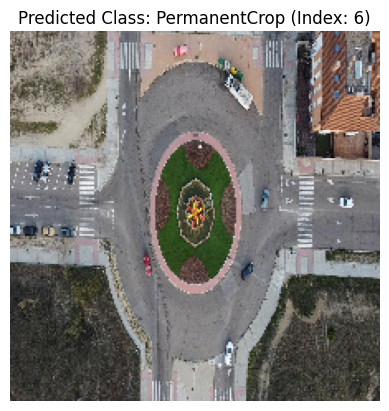

Raw prediction probabilities: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [17]:
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input # Make sure this is imported if not already

# Load and preprocess the sample image
img_path = 'sample/img.jpg'  # Change this to test other images like 'sample/image2.jpg'
img = keras_image.load_img(img_path, target_size=(224, 224))
img_array = keras_image.img_to_array(img)

# Apply VGG16 preprocessing (BGR conversion and mean subtraction)
# Ensure preprocess_input is imported from tf.keras.applications.vgg16
img_preprocessed = preprocess_input(tf.cast(img_array, tf.float32))

# Add batch dimension
img_batch = np.expand_dims(img_preprocessed, axis=0)

# Make prediction
predictions = dense_model.predict(img_batch)
predicted_class_index = np.argmax(predictions[0])

# Get class names (assuming ds_info contains class names from tfds.load)
# If ds_info is not available in this scope, you might need to redefine class_names
# based on the EuroSAT dataset classes.
try:
    class_names = ds_info.features['label'].names
    predicted_class_name = class_names[predicted_class_index]
except NameError:
    # Fallback if ds_info is not available - you might need to adjust these
    class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
                   'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
                   'River', 'SeaLake']
    if predicted_class_index < len(class_names):
        predicted_class_name = class_names[predicted_class_index]
    else:
        predicted_class_name = "Unknown Index"


# Display the image and prediction
plt.imshow(img) # Show the original image before BGR conversion and mean subtraction
plt.title(f'Predicted Class: {predicted_class_name} (Index: {predicted_class_index})')
plt.axis('off')
plt.show()

print(f"Raw prediction probabilities: {predictions[0]}")